### PAIR IV MÓDULO 3: Asunciones Regresión Lineal

Para los ejercicios de Pair hemos utilizado el siguiente dataset: [Spotify Tracks Dataset](https://www.kaggle.com/datasets/maharshipandya/-spotify-tracks-dataset)

In [46]:
import numpy as np
import pandas as pd
import random 

import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
import researchpy as rp
from scipy.stats import levene
from scipy.stats import skew
from scipy.stats import kurtosistest
from scipy.stats import kstest


plt.rcParams["figure.figsize"] = (10,8) 

import warnings
warnings.filterwarnings('ignore')

pd.options.display.max_columns = None

In [47]:
df = pd.read_pickle('data/spotify_songs_limpio.pkl')
df.head(2)

,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,0amhzLwuGALhb81XyyuUlN,Chronic Law,Stay Real,Stay Real,18,196571,False,0.544,0.689,C,-7.764,minor,0.246,0.147,0.0,0.1510,0.422,87.328,compas_4,j-dance
1,3YQ5NYk2legzeloibRyXn1,Marksman,Verified Choppa 2,Verified Choppa 2,58,139093,False,0.725,0.604,G,-5.874,major,0.408,0.117,0.0,0.0855,0.449,199.995,compas_4,dancehall


El objetivo de este pairprgramming es que evaluéis si vuestro set de datos cumple todas las asunciones que se deben cumplir para hacer una regresión lineal. Recordamos que estas asunciones son:

`[Cada asunción la deberéis testar de forma visual y analítica]`

- Normalidad (ya la deberíais haber evaluado)



In [50]:
numericas = df.select_dtypes(np.number)
columnas_numeric = numericas.columns

normales = []
no_normales = []

for colum in columnas_numeric:
    pvalue = kstest(df[colum], 'norm')[1]
    if pvalue > 0.05:
        normales.append(f'{colum} (pvalue = {pvalue})')
    else:
        no_normales.append(f'{colum} (pvalue = {pvalue})')

print(f'Son normales las columnas:\n {normales} (pvalues > 0.05)')
print(f'Son no normales las columnas:\n {no_normales} (pvalues < 0.05)')

Son normales las columnas:
 [] (pvalues > 0.05)
Son no normales las columnas:
 ['popularity (pvalue = 0.0)', 'duration_ms (pvalue = 0.0)', 'danceability (pvalue = 0.0)', 'energy (pvalue = 0.0)', 'loudness (pvalue = 0.0)', 'speechiness (pvalue = 0.0)', 'acousticness (pvalue = 0.0)', 'instrumentalness (pvalue = 0.0)', 'liveness (pvalue = 0.0)', 'valence (pvalue = 0.0)', 'tempo (pvalue = 0.0)'] (pvalues < 0.05)


- Homogeneidad de varianzas


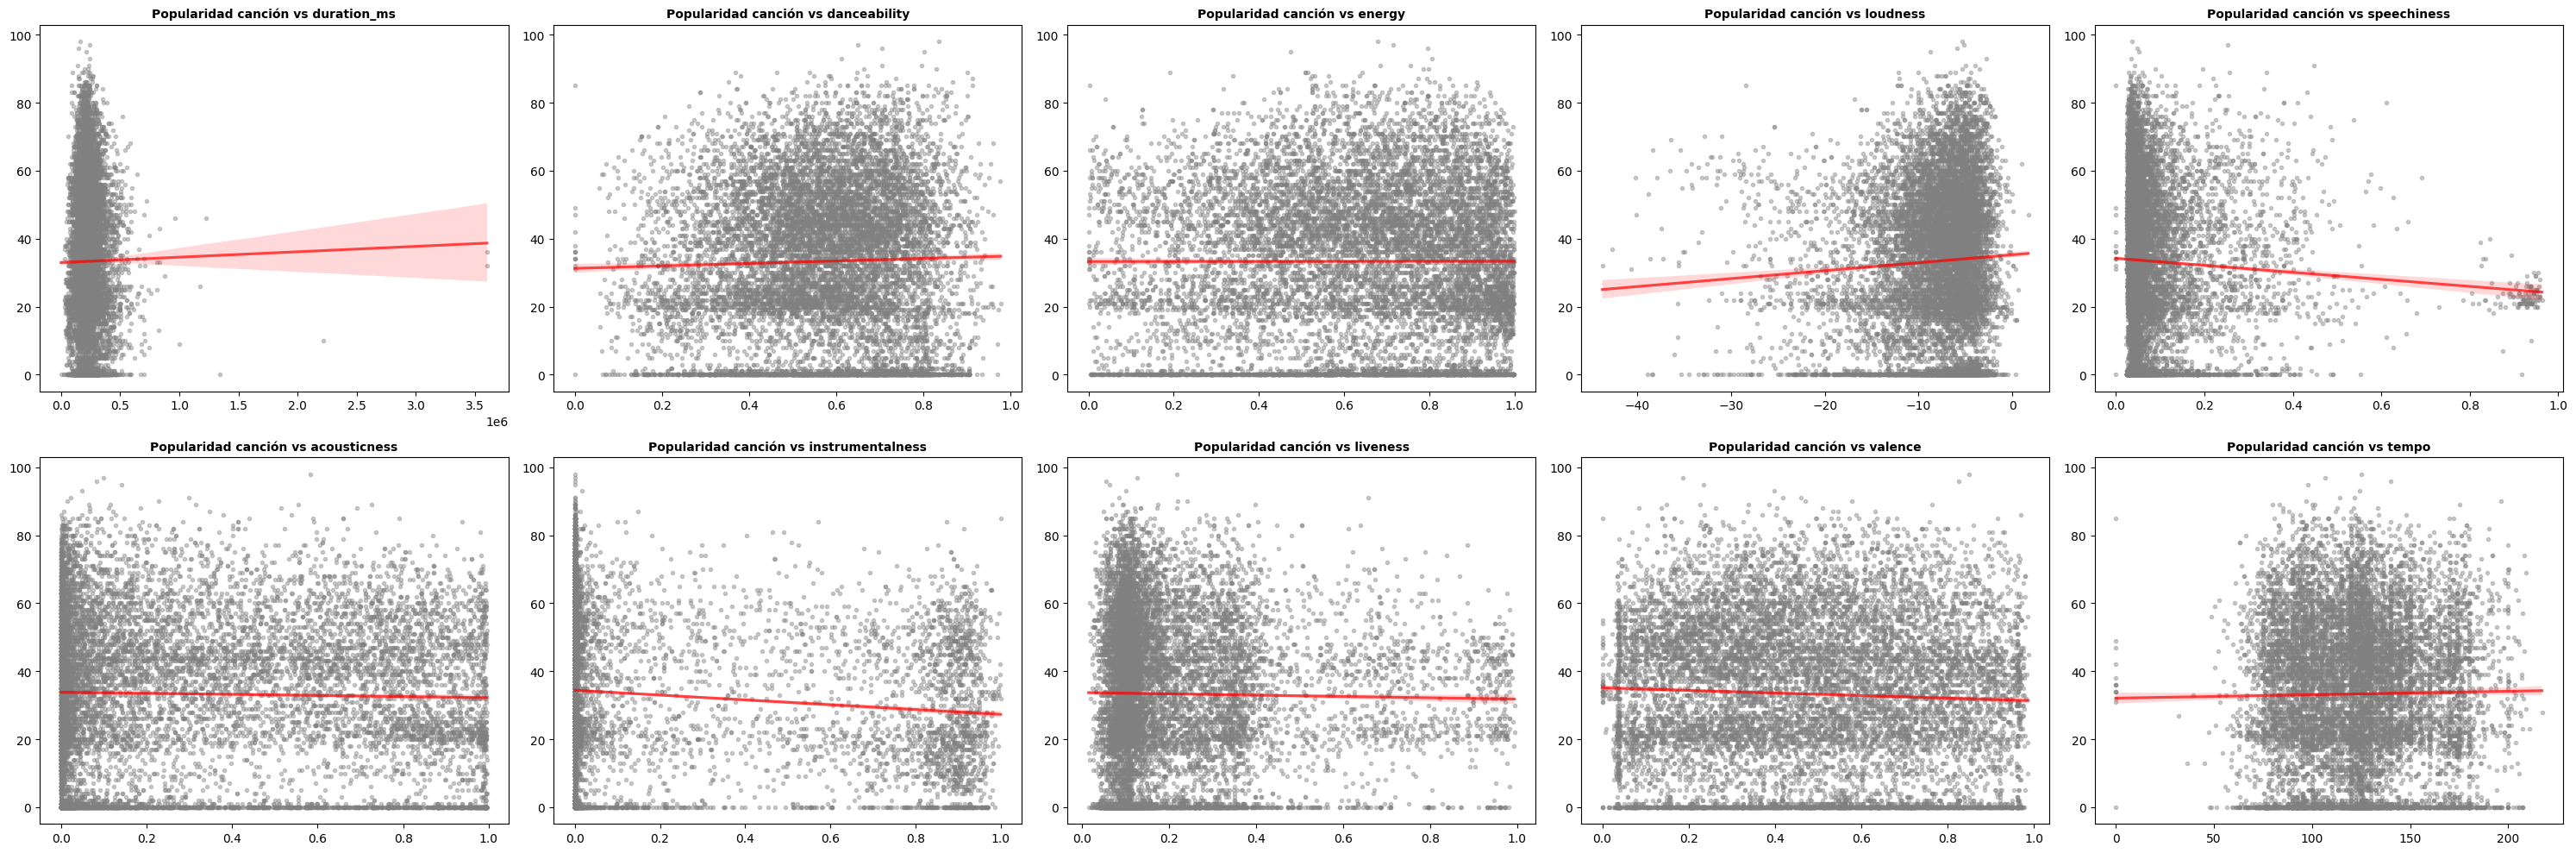

In [51]:
# como solo nos interesa de las predictoras, vamos a sacar "popularity"
predictoras_col = numericas.drop("popularity", axis= 1).columns

fig, axes = plt.subplots(nrows = 2, ncols = 5, figsize = (30, 10))

axes = axes.flat

columnas_numeric = numericas.columns
columnas_numeric = columnas_numeric.drop("popularity")

for i, colum in enumerate(columnas_numeric):
    sns.regplot(
        x = df[colum], 
        y = df["popularity"], 
        color = "gray", 
        marker = ".", 
        scatter_kws = {"alpha": 0.4}, 
        line_kws = {"color": "red", "alpha": 0.7 }, 
        ax = axes[i])
    
    axes[i].set_title(f"Popularidad canción vs {colum}", fontsize = 10, fontweight = "bold")
    axes[i].set_xlabel("")
    axes[i].set_ylabel("")
    
fig.tight_layout();

Visualmente, diríamos que son homogéneas:
- "danceability"
- "energy"
- "valance"
- "tempo"

In [52]:
resultados = {}

for col in predictoras_col:

    statistic, p_val = levene(df[col], df.popularity, center='median')

    resultados[col] = p_val

resultados

{'duration_ms': 0.0,
 'danceability': 0.0,
 'energy': 0.0,
 'loudness': 0.0,
 'speechiness': 0.0,
 'acousticness': 0.0,
 'instrumentalness': 0.0,
 'liveness': 0.0,
 'valence': 0.0,
 'tempo': 6.476336079540104e-131}

Ahora vamos a comprobar la homocedastidad de las variables categóricas:

In [53]:
# VAmos a filtrar únicamente las de tipo categórico que 
predict_cat = df.select_dtypes(include=["O", "bool"]).columns[4:-1]
predict_cat

Index(['explicit', 'key', 'mode', 'time_signature'], dtype='object')

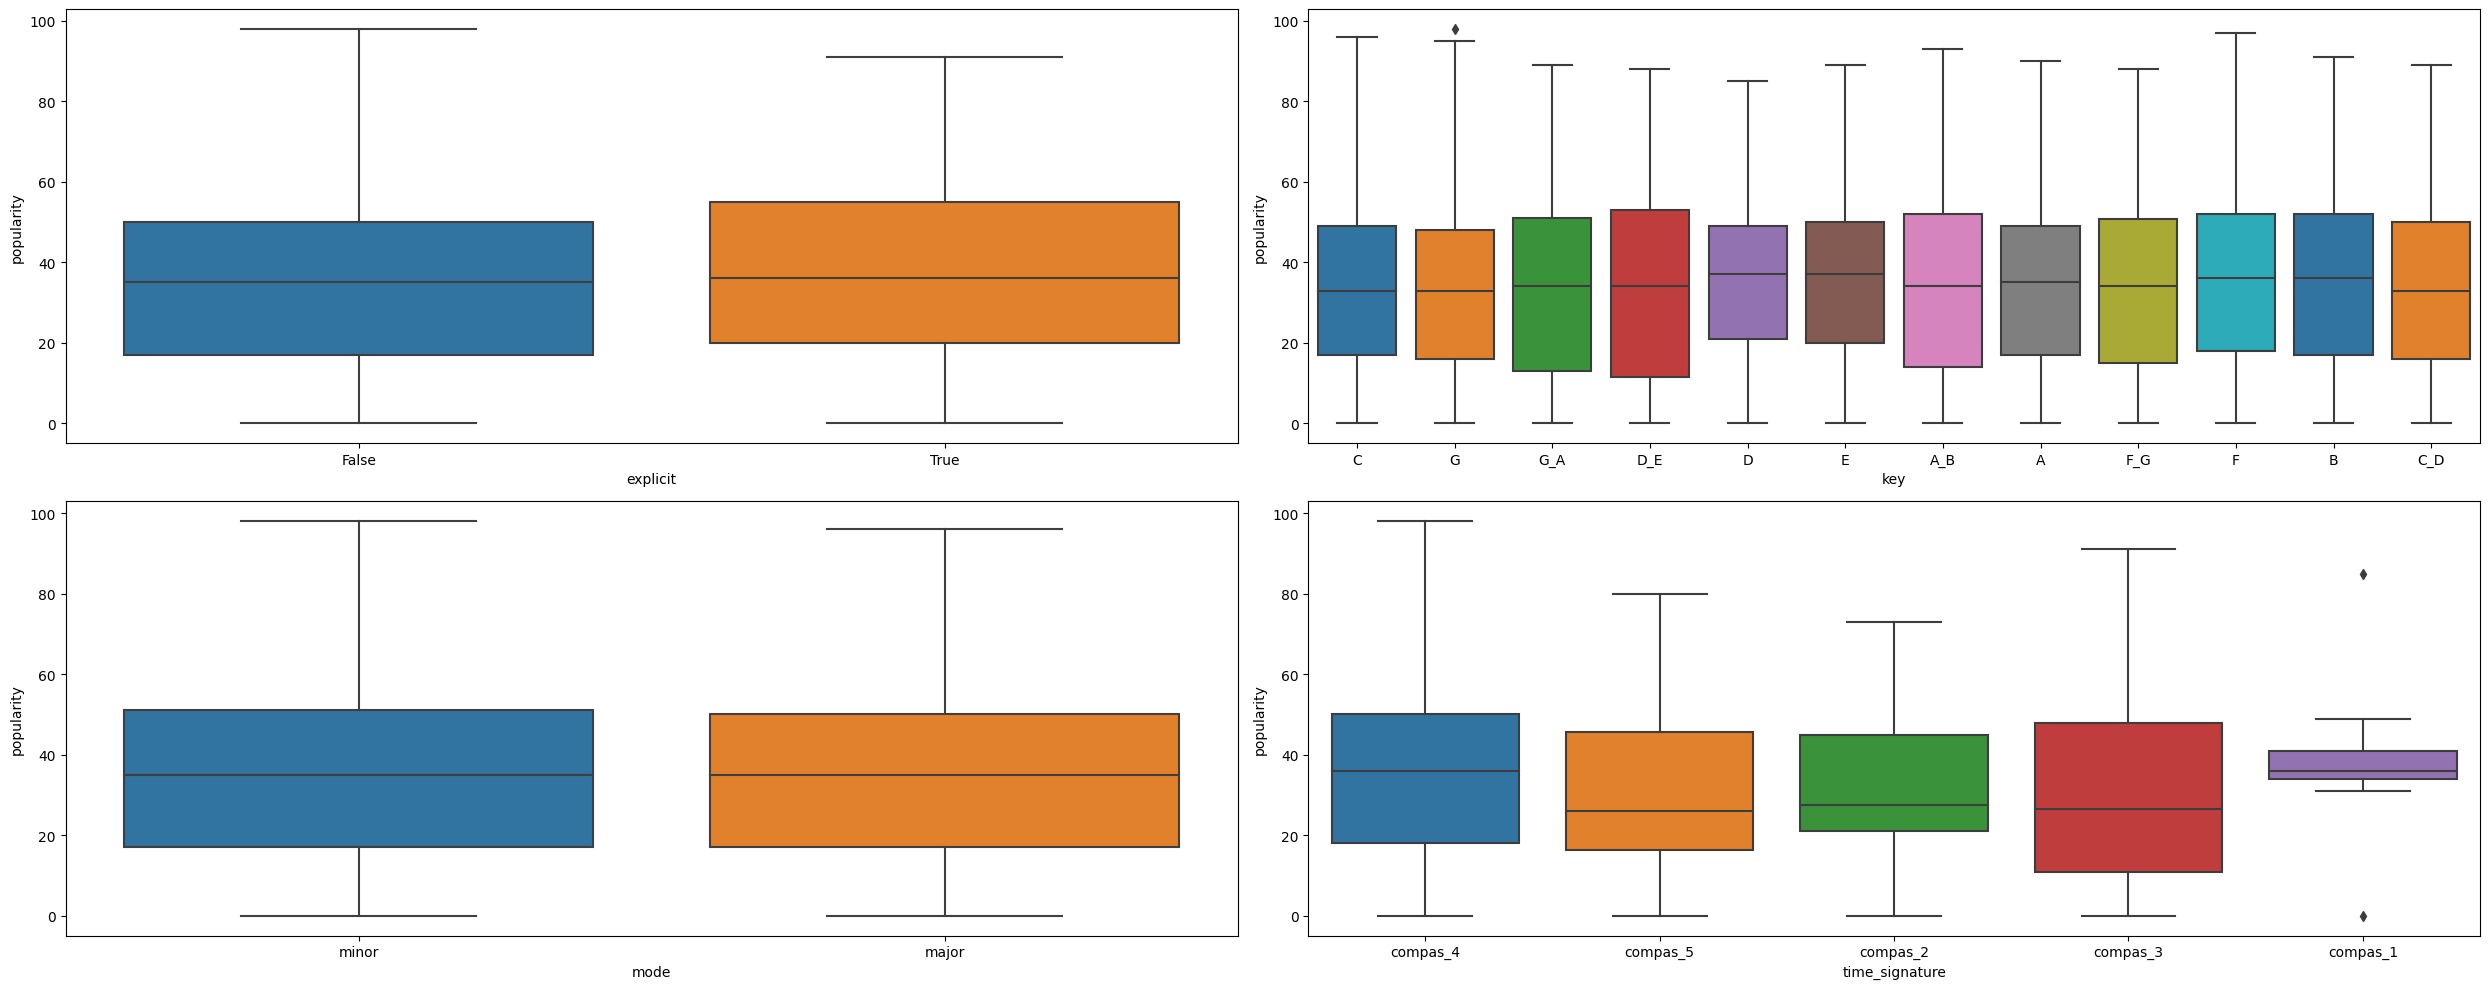

In [54]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(25, 10))

axes = ax.flat

for i, col in enumerate(predict_cat):
    sns.boxplot(x = col,  y= 'popularity', data= df, palette = 'tab10', ax= axes[i])
    fig.tight_layout();

Visualmente, parecen homocedásticas todas, "time_signature" porque, teniendo un rango de 0 a 100, la diferencia entre la media más baja (aprox 30) y la más alta (aprox 40) no la hemos considerado relevante.

In [55]:
for col in predict_cat:
    variables = []
    for value in df[col].unique():
        variable_name = value  # Asigna el nombre de la variable
        variable_data = df[df[col] == value]["popularity"]  # Obtiene los datos de la variable
        globals()[variable_name] = variable_data  # Crea la variable global
        variables.append(variable_name)  # Agrega el nombre de la variable a la lista
    result = stats.levene(*[globals()[var] for var in variables], center='median')

# Imprimir el resultado
    print(f"{col}: {result}")


explicit: LeveneResult(statistic=25.646289962207035, pvalue=4.161714356347222e-07)
key: LeveneResult(statistic=6.810938887141883, pvalue=1.5370827063507047e-11)
mode: LeveneResult(statistic=7.335677206136514, pvalue=0.006769506945078356)
time_signature: LeveneResult(statistic=5.443184405455611, pvalue=0.0002242455072642544)


Al contrario de lo que habíamos visto de manera visual, en nuestro dataframe no tenemos ninguna variable homocedástica (todas tienen una p-value < 0.05).

- Independencia de las variables

Vamos a ver, en primer lugar, la independencia de las numéricas (Pearson)

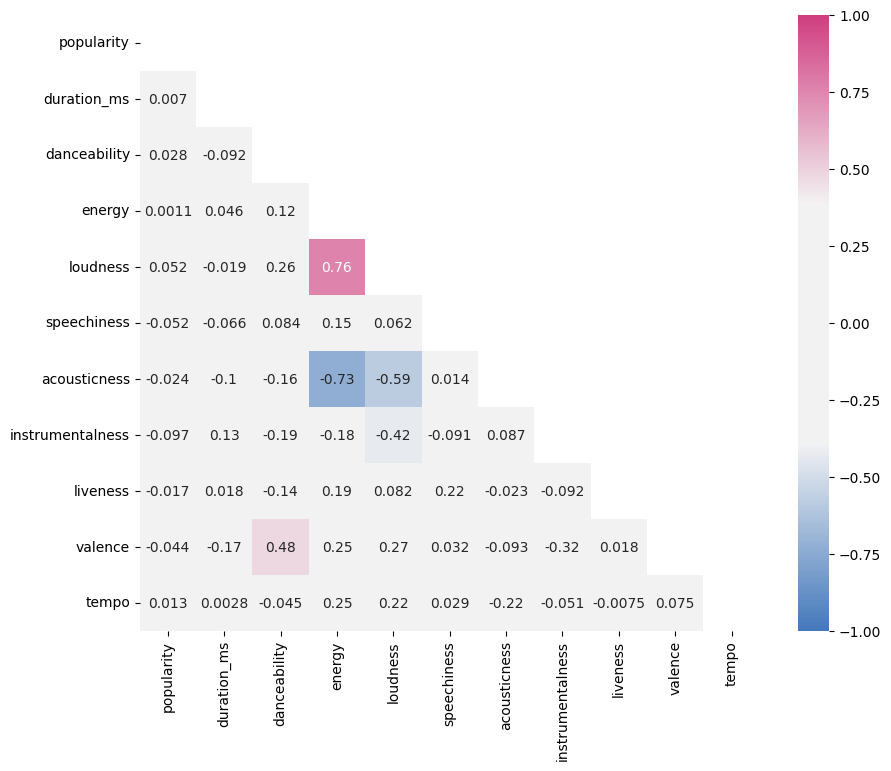

In [56]:
numericas = df.select_dtypes(np.number)

mask = np.triu(np.ones_like(numericas.corr(), dtype = np.bool_))

cmap = sns.diverging_palette(250, 349, sep=100, as_cmap=True)

sns.heatmap(numericas.corr(), 
           cmap = cmap, 
            mask = mask,
           annot = True,
           vmin= -1,
           vmax= 1);

In [57]:
categoricas_col = df.select_dtypes(include=["O", "bool"]).columns[4:-1]
categoricas_col

Index(['explicit', 'key', 'mode', 'time_signature'], dtype='object')

In [58]:
#Vamos a crear un dataframe con todos los Chi-cuadrados
#Empezamos creando el dataframe
df_chis = pd.DataFrame(columns= categoricas_col, index = categoricas_col)

In [59]:
# Vamos a insertar los valores:
from itertools import combinations
combinaciones = list(combinations(categoricas_col,2))

In [60]:
for i in combinaciones:

    crosstab, test_results, expected = rp.crosstab(df[i[0]], df[i[1]],
                                               test= "chi-square",
                                               expected_freqs= True,
                                               prop= "cell")
    df_chis.loc[i[0], i[1]] = test_results.loc[2, 'results']
    df_chis.loc[i[1], i[0]] = test_results.loc[2, 'results']
    df_chis.loc[i[0], i[0]] = 1.00
    df_chis.loc[i[1], i[1]] = 1.00

In [61]:
df_chis = df_chis.astype('float')
df_chis.dtypes

explicit          float64
key               float64
mode              float64
time_signature    float64
dtype: object

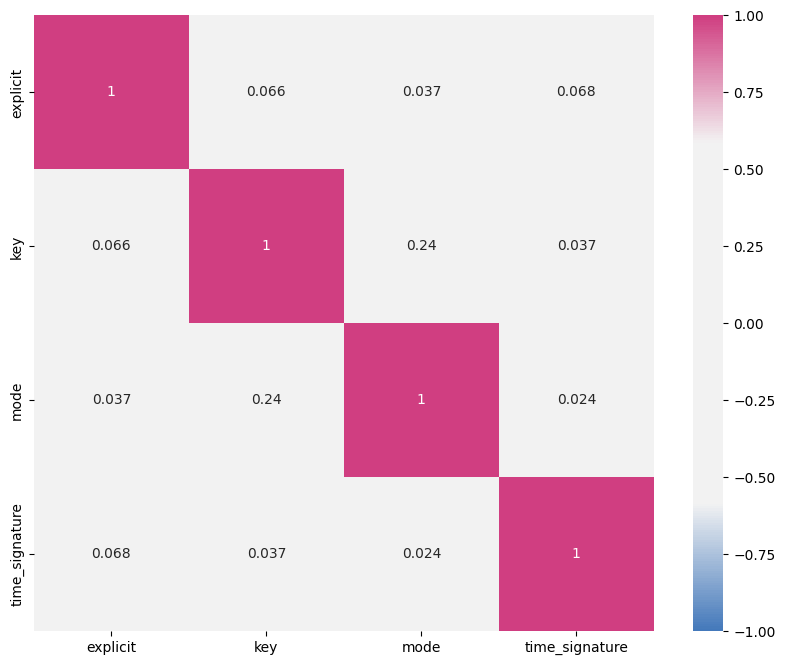

In [62]:
cmap = sns.diverging_palette(250, 349, sep=150, as_cmap=True)

sns.heatmap(df_chis, 
           cmap = cmap, 
           annot = True,
           vmin= -1,
           vmax= 1);

Revisando todas las variables (tanto numéricas como categóricas), encontramos que todas ellas son independientes.

**CONCLUSIÓN** No podemos aplicar Regresión Lineal porque no se cumplen dos de las tres asunciones:
1. Nuestra variable respuesta no es normal ni se puede normalizar.
2. Nuestras variables predictoras son heterocedásticas.
3. La única asunción que se cumple es la de la independencia de las VP (a excepción de "energy" que correlaciona positivamente con "loudness" y negativamente con "accousticness").